In [2]:
# Bunch of imports
import sys
import argparse
import csv
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [7, 4]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

/home/pi/.local/lib/python3.7/site-packages/scipy/__init__.py:137: UserWarning: NumPy 1.16.5 or above is required for this version of SciPy (detected version 1.16.2)
  UserWarning)


RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

ImportError: numpy.core.multiarray failed to import

In [ ]:
# Auxiliary function to select a file using a Qt5 dialog
def getDataFile():
  try:
    from PyQt5.QtWidgets import QApplication, QFileDialog
    qapp = QApplication([])
    file_name, _ = QFileDialog.getOpenFileName(caption="Select csv", filter="CSV Files (*.csv);;All Files (*)")
    return file_name
  except ModuleNotFoundError:
    print("WARNING: PyQt5 seems not to be installed. Files cannot be selected using QFileDialog.")
    return None

In [ ]:
# Reads a CSV file and returns a dictionary whose keys are the header entries.
# Optionally, a selected number of fields can be specified.
# You can also ask the result to be returned as a plain tuple rather than a dictionary.
#
# EXAMPLES
#
# 1) Load everything as a dictionary:
#       data = loadCsv('my_data.csv')
# 'data' will be like: {'field1': np.array(...), 'field2': np.array(...), ...}
#
# 2) Load only the given fields:
#       data = loadCsv('my_data.csv', 'field8', 'field5')
# 'data' will cointain {'field8': np.array(...), 'field5': np.array(...)}
# 
# 3) Do not create a dictionary:
#       f8,f5 = loadCsv('my_data.csv', 'field8', 'field5', as_dict=False)
# This is equivalent to the following:
#       data = loadCsv('my_data.csv', 'field8', 'field5')
#       f8 = data.get('filed8')
#       f5 = data.get('filed5')
#
def loadCsv(file_name, *fields, as_dict=True):
  with open(file_name) as f:
    # read just the header
    header = f.readline().strip().replace(" ", "").split(",")
    idx = []
    if len(fields) == 0:
      fields = header
      idx = range(len(header))
    else:
      for elem in fields:
        if elem not in header:
          raise ValueError(f"Field '{elem}' is not part of the header of the given file '{file_name}'. The header is: '{','.join(header)}'")
        idx.append(header.index(elem))
    # read again the file, using numpy
    data = np.loadtxt(f, delimiter=",")
    if as_dict:
      return {header[i]: data[:,i] for i in idx}
    else:
      return (data[:,i] for i in idx)

In [ ]:
# Creates a set of subdictionaries from a dictionary created using loadCsv.
# This function is better explained via an example:
# Assume that you have the following CSV, containing data from a set of
# tests, each one having a different 'test_id' (do not focus on the content
# of 'input' and 'output'):
#
#   test_id, input, output
#         1,    10,     20
#         1,    20,     30
#         1,    30,     40
#         2,    40,     50
#         3,    50,     60
#         3,    60,     70
#         2,    70,     80
#
# It would be processed by a "plain" call to loadCsv as the following dict:
#
#   data = {
#     'test_id': np.array([1,1,1,2,3,3,2]),
#     'input': np.array([10,20,30,40,50,60,70]),
#     'output': np.array([20,30,40,50,60,70,80])
#   }
#
# However, you might want to group data depending on the test id.
# To do that, you can call thus function as:
# 
#   classify('test_id', data)
#
# The output will be another dictionary in the following form:
#
#   {
#     1: {
#       'test_id': np.array([1,1,1]),
#       'input': np.array([10,20,30]),
#       'output': np.array([20,30,40])
#     },
#     2: {
#       'test_id': np.array([2,2]),
#       'input': np.array([40,70]),
#       'output': np.array([50,80])
#     },
#     3: {
#       'test_id': np.array([3,3]),
#       'input': np.array([50,60]),
#       'output': np.array([60,70])
#     }
#   }
#
# Note that each sub-dictionary contains the only data related to a specific 'test_id' value.
def classify(key, data_dict):
  if key not in data_dict:
    raise ValueError(f"Key '{key}' is not contained in the input dictionary. Valid keys are '{data_dict.keys()}'")
  key_signal = data_dict.get(key)
  out = dict()
  for val in np.unique(data_dict.get(key)):
    idx = key_signal==val
    out[val] = dict()
    for k,v in data_dict.items():
      out[val][k] = v[idx]
  return out

In [ ]:
# Measured dynamic parameters
g = 9.806 # gravity
M = 0.439 # mass of the base
m1 = 0.012 # mass of the plastic component that connects the base and the rod 
m2 = 0.019 # mass of the rod
m3 = 0.031 # mass of the terminal weight
ell = 0.495 # length of the rod
mt = M + m1 + m2 + m3
mu = m2*ell/2 + m3*ell
# The missing parameters are:
# - Friction coefficients (for the base and the pendulum)
# - Total inertia of the rod and weight
# - Gain of the motor

In [ ]:
######################
## ANGULAR DYNAMICS ##
######################
# Try to perform identification of the parameters. The model for the pendulum
# (with no moving base!) is assumed to be given by:
#
#   \ddot{\theta} = - \frac{m*ell}{I0} g \sin\theta
#                   - \frac{\mu_d}{I0} \dot{\theta}
#                   - \frac{\mu_s}{I0} \tanh{k*\dot{\theta}}
#
# We thus run a regression to identify the vector [\frac{m*ell}{I0}, \frac{\mu_d}{I0}, \frac{\mu_s}{I0}]
# and then extract the required values

data_dict = loadCsv('logged_angles.csv', 'packet', 'time_us', 'angle')
data = classify('packet', data_dict)

# Make the problem "deterministic" (same random seed for each run)
np.random.seed(1993)

# frequency and order of the butterworth filter used in smoothing
fc = 15
Nf = 4

# The problem has to be written as A*X=B, the following does precisely this!
RegA = np.zeros((0,2))
RegB = np.zeros((0,1))

for test_id, test_data in data.items():
#     if test_id != 3 and test_id != 4:
#         continue
    t = test_data.get('time_us')
    t = t / 1e6
    t = t - t[0] # t[0]=0
    tv = t[1:-1] # for velocity and acceleration signals
    dt = np.average(np.diff(t))
    # raw signals
    praw = test_data.get('angle') * (2*np.pi/4000)
    vraw = np.convolve(praw, [0.5, 0, -0.5], 'valid') / dt
    araw = np.convolve(praw, [1.0, -2.0, 1.0], 'valid') / (dt**2)
    # filter the signals
    b,a = signal.butter(Nf, 2*(dt*fc)) # [1],[1,0] = no filter
    p = signal.filtfilt(b, a, praw, padtype=None)
    v = signal.filtfilt(b, a, vraw, padtype=None)
    a = signal.filtfilt(b, a, araw, padtype=None)
    # cut left/right ends (to avoid issues with the butterworth filter)
    ncut = 2*Nf+1
    P = p[ncut+1:-(ncut+1)]
    V = v[ncut:-ncut]
    A = a[ncut:-ncut]
    # select just some samples to avoid overfitting
    keep_ratio = 5
    keep_size = round(P.size/keep_ratio)
    keep_this = np.random.choice(P.size, size=(keep_size,), replace=False)
    P = P[keep_this].reshape(-1,1)
    V = V[keep_this].reshape(-1,1)
    A = A[keep_this].reshape(-1,1)
    # Extend the regression matrix and vector
    RegA = np.vstack((  RegA , np.hstack(( g*np.sin(P) , V ))  ))
    RegB = np.vstack((RegB, -A))
    
# solve the problem  min || RegY*X - RegB ||
X = np.linalg.lstsq(RegA, RegB, rcond=None)[0].reshape(-1)

# Extract "real parameters":
I0 = ( (m2/2+m3)*ell ) / X[0]
I = I0 - (m2/4+m3) * ell**2
tau_d = X[1] * I0
print("I:", I)
print("tau_d:", tau_d)

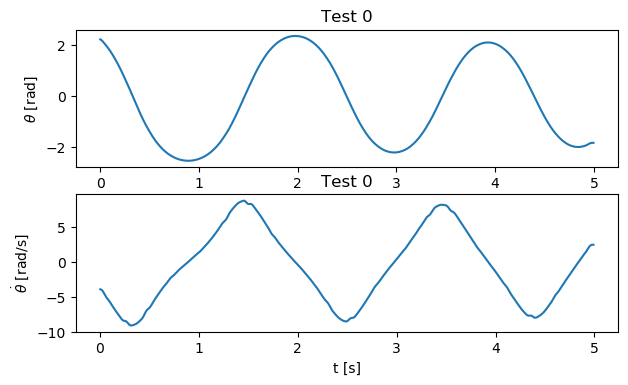

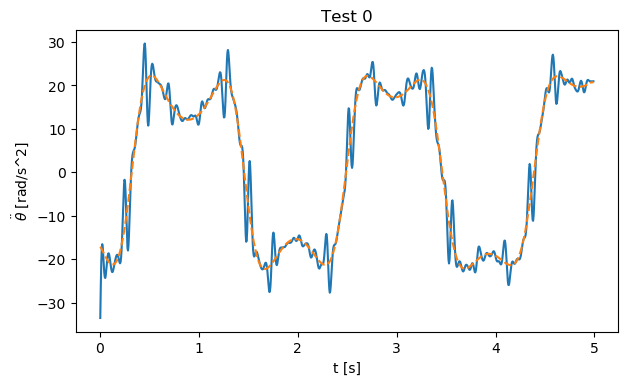

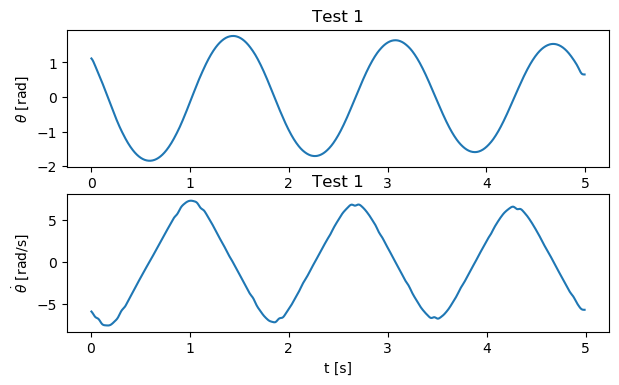

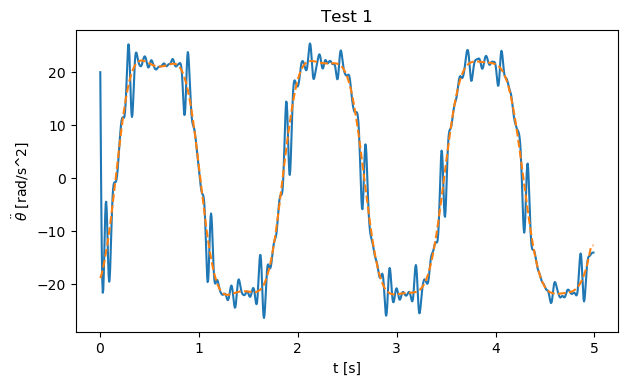

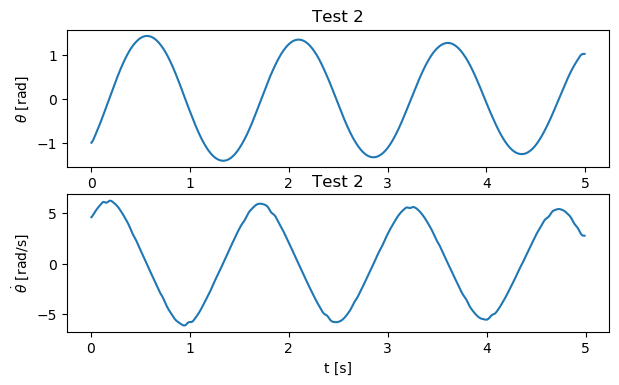

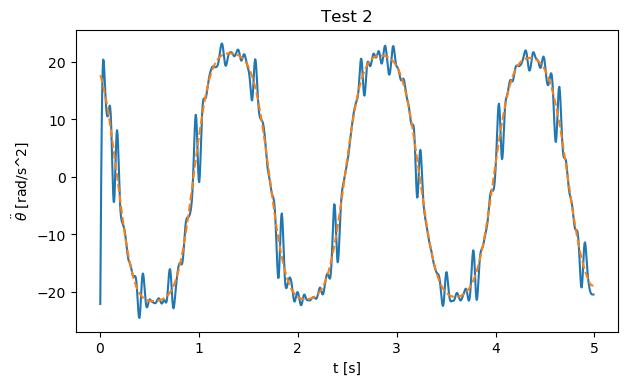

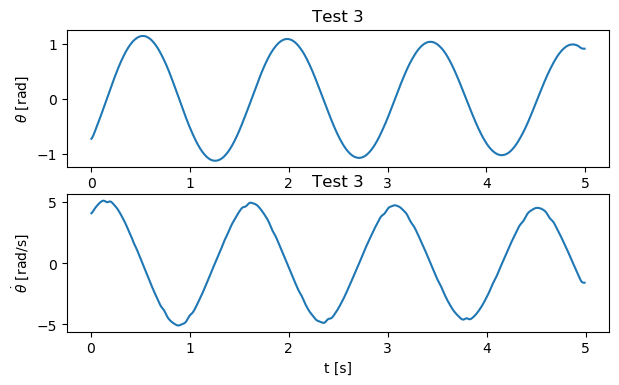

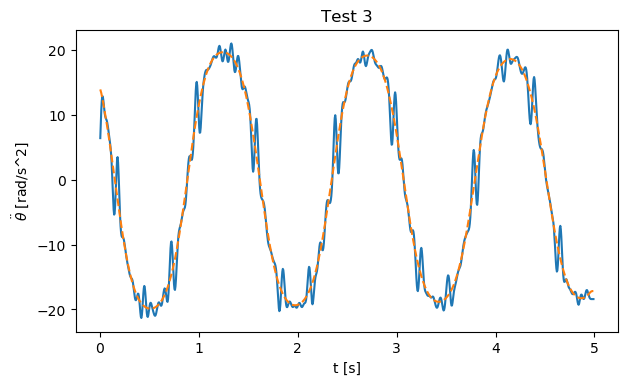

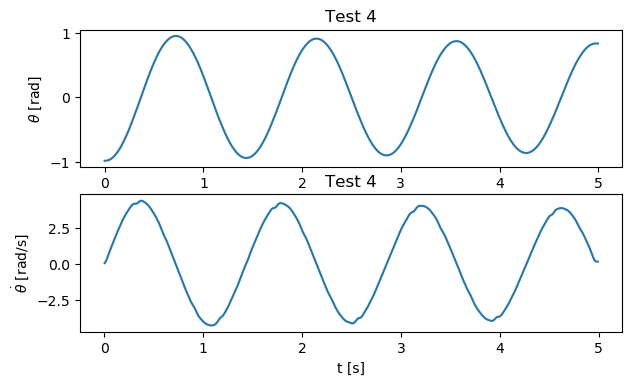

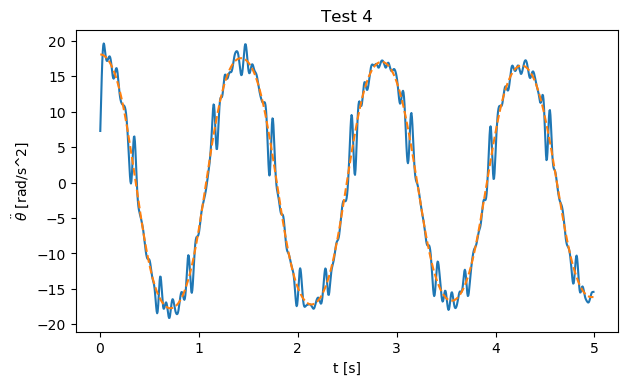

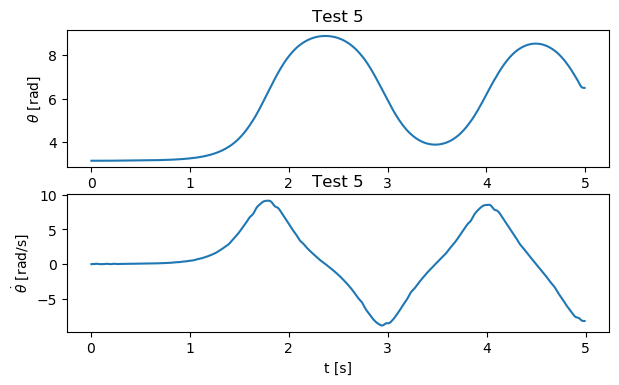

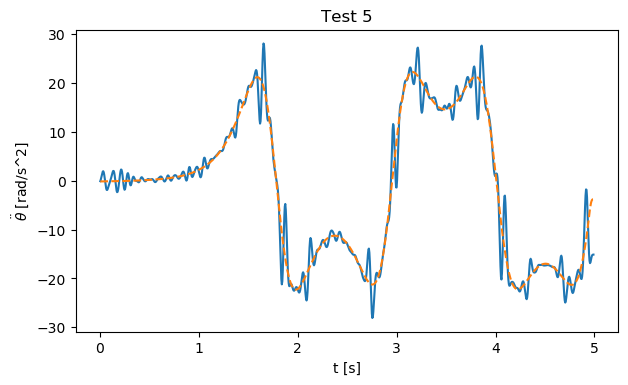

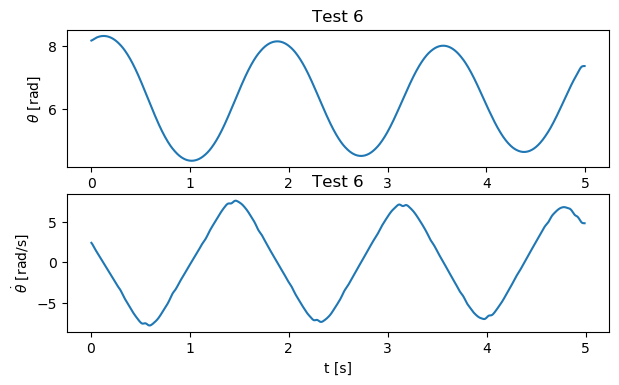

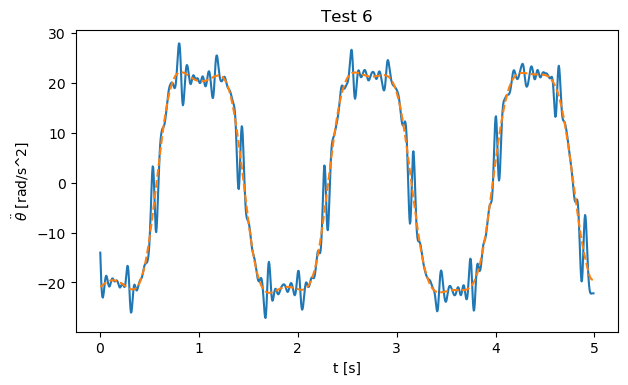

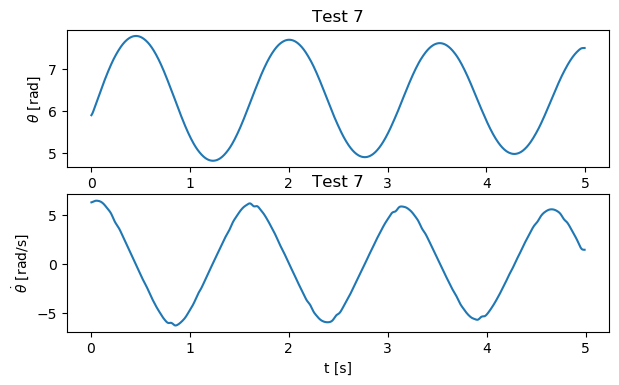

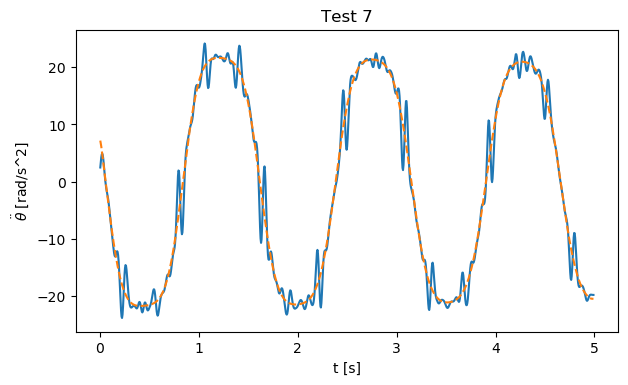

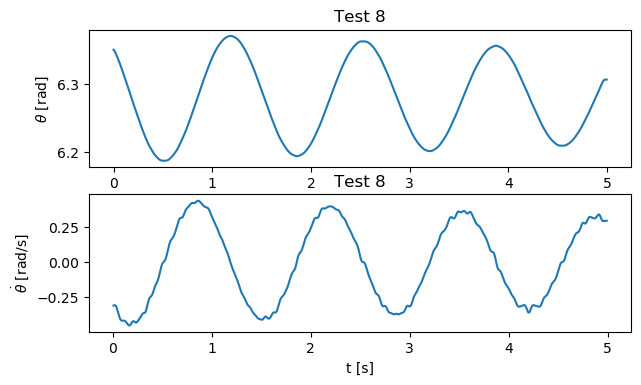

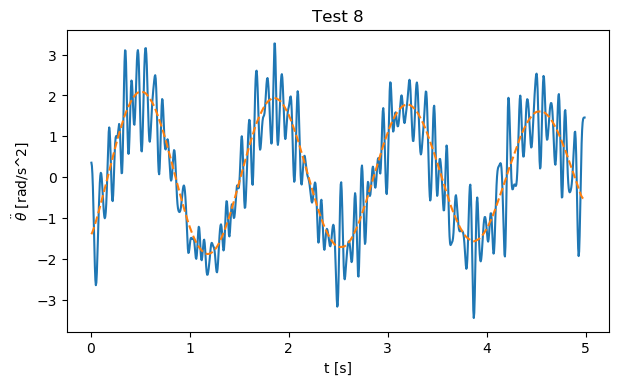

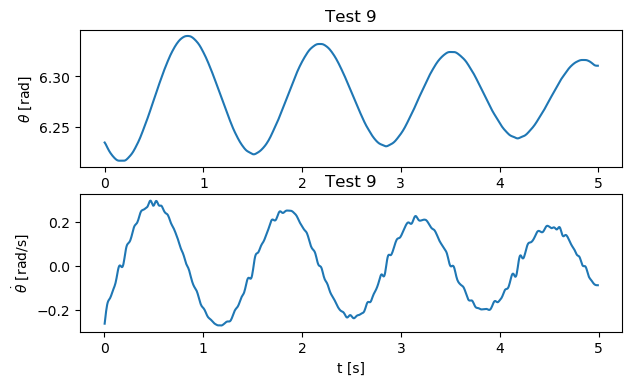

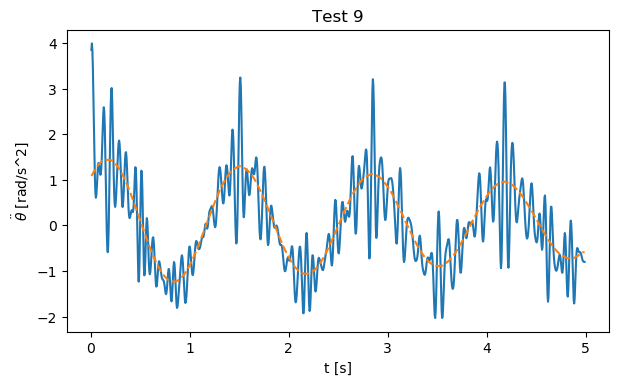

In [7]:
# Show results

for test_id, test_data in data.items():
#     fig,(pos_ax,vel_ax,acc_ax) = plt.subplots(3,1)
    fig_posvel,(pos_ax,vel_ax) = plt.subplots(2,1)
    fig_acc,acc_ax = plt.subplots()
#     vel_fig,vel_ax = plt.subplots()
#     acc_fig,acc_ax = plt.subplots()
    t = test_data.get('time_us')
    t = t / 1e6
    t = t - t[0] # t[0]=0
    t2 = t[1:-1] # for velocity and acceleration signals
    dt = np.average(np.diff(t))
    # raw signals
    praw = test_data.get('angle') * (2*np.pi/4000)
    vraw = np.convolve(praw, [0.5, 0, -0.5], 'valid') / dt
    araw = np.convolve(praw, [1.0, -2.0, 1.0], 'valid') / (dt**2)
    # filter the signals
    b,a = signal.butter(Nf, 2*(dt*fc)) # [1],[1,0] = no filter
    pos = signal.filtfilt(b, a, praw, padtype=None)
    vel = signal.filtfilt(b, a, vraw, padtype=None)
    acc = signal.filtfilt(b, a, araw, padtype=None)
    # "prediction"
    ahat = - ((m2/2+m3)*ell/I0) * g * np.sin(pos[1:-1]) - (tau_d/I0) * vel
    pos_ax.plot(t, pos)
    vel_ax.plot(t2, vel)
    acc_ax.plot(t2, acc)
    acc_ax.plot(t2, ahat, '--')
    
    pos_ax.set_title(f"Test {int(test_id)}")
    pos_ax.set_xlabel('t [s]')
    pos_ax.set_ylabel('$\\theta$ [rad]')
    vel_ax.set_title(f"Test {int(test_id)}")
    vel_ax.set_xlabel('t [s]')
    vel_ax.set_ylabel('$\\dot{\\theta}$ [rad/s]')
    acc_ax.set_title(f"Test {int(test_id)}")
    acc_ax.set_xlabel('t [s]')
    acc_ax.set_ylabel('$\\ddot{\\theta}$ [rad/s^2]')
    

In [8]:
#####################
## LINEAR DYNAMICS ##
#####################
# Try to perform identification of the parameters. The model for the base
# (with no swinging pendulum!) is assumed to be given by:
#
#   u = \frac{M}{\alpha} \ddot{p}
#         + \frac{\beta}{\alpha} \dot{p}
#             + u_0
#
# We thus run a regression to identify the vector [\frac{M}{\alpha}, \frac{\beta}{\alpha}, u_0]
# and then extract the required values

data_dict = loadCsv('logged_motion.csv', 'pwm', 'time_us', 'position')
data = classify('pwm', data_dict)

# Make the problem "deterministic" (same random seed for each run)
np.random.seed(1993)

# frequency and order of the butterworth filter used in smoothing
fc = 10
Nf = 4

# The problem has to be written as A*X=B, the following does precisely this!
RegA = np.zeros((0,4))
RegB = np.zeros((0,1))

for test_id, test_data in data.items():
    t = test_data.get('time_us')
    t = t / 1e6
    t = t - t[0] # t[0]=0
    tv = t[1:-1] # for velocity and acceleration signals
    dt = np.average(np.diff(t))
    # raw signals
    praw = test_data.get('position')
    vraw = np.convolve(praw, [0.5, 0, -0.5], 'valid') / dt
    araw = np.convolve(praw, [1.0, -2.0, 1.0], 'valid') / (dt**2)
    uraw = test_data.get('pwm')
    # filter the signals
    bfilt, afilt = signal.butter(Nf, 2*(dt*fc)) # [1],[1,0] = no filter
    p = signal.filtfilt(bfilt, afilt, praw, padtype=None)
    v = signal.filtfilt(bfilt, afilt, vraw, padtype=None)
    a = signal.filtfilt(bfilt, afilt, araw, padtype=None)
    u = signal.filtfilt(bfilt, afilt, uraw, padtype=None)
    # cut left/right ends (to avoid issues with the butterworth filter)
    ncut = 2*Nf+1
    P = p[ncut+1:-(ncut+1)]
    V = v[ncut:-ncut]
    A = a[ncut:-ncut]
    U = u[ncut:-ncut]
    # select just some samples to avoid overfitting
    keep_ratio = 5
    keep_size = round(P.size/keep_ratio)
    keep_this = np.random.choice(P.size, size=(keep_size,), replace=False)
    P = P[keep_this].reshape(-1,1)
    V = V[keep_this].reshape(-1,1)
    A = A[keep_this].reshape(-1,1)
    U = U[keep_this].reshape(-1,1)
    # Extend the regression matrix and vector
    RegA = np.vstack((  RegA , np.hstack(( A , V , np.ones(P.shape) , np.sign(V) ))  ))
    RegB = np.vstack((RegB, U))
    
# solve the problem  min || RegA*X - RegB ||
X = np.linalg.lstsq(RegA, RegB, rcond=None)[0].reshape(-1)

# Extract "real parameters":
alpha = M / X[0]
beta = alpha * X[1]
u0 = X[2]
fsa = X[3]
print("alpha:", alpha)
print("beta:", beta)
print("u0:", u0)
print("fsa:", fsa)

alpha: 0.030621454694666015
beta: 12.34126591549826
u0: 1.313910147328636
fsa: 16.149267140580772


<ipython-input-9-59c0e6d41f11>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig_posvel,(pos_ax,vel_ax) = plt.subplots(2,1)
<ipython-input-9-59c0e6d41f11>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig_acc,acc_ax = plt.subplots()


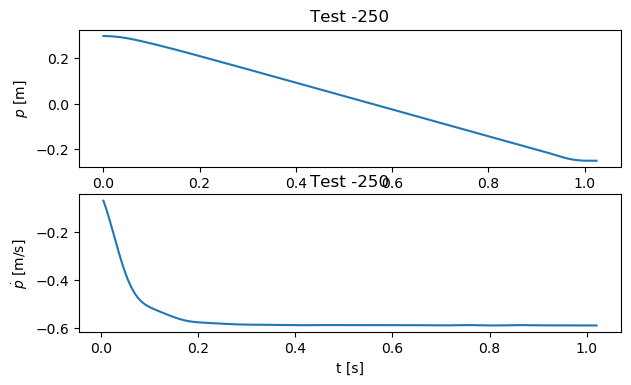

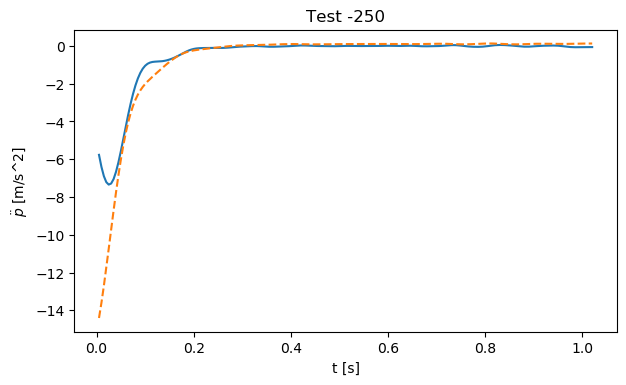

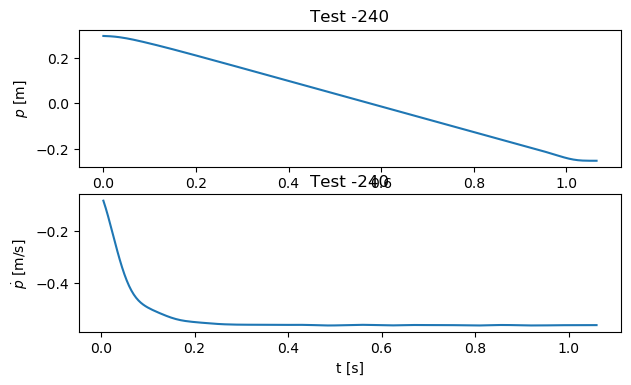

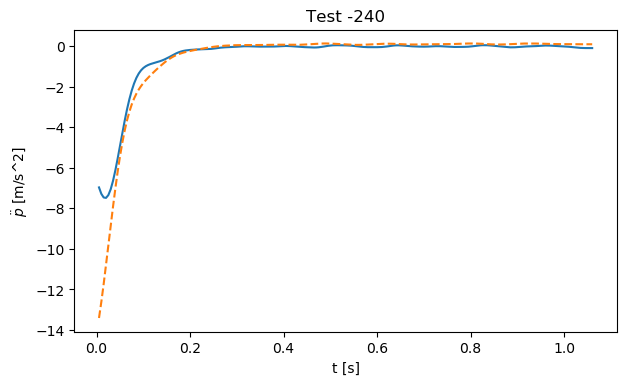

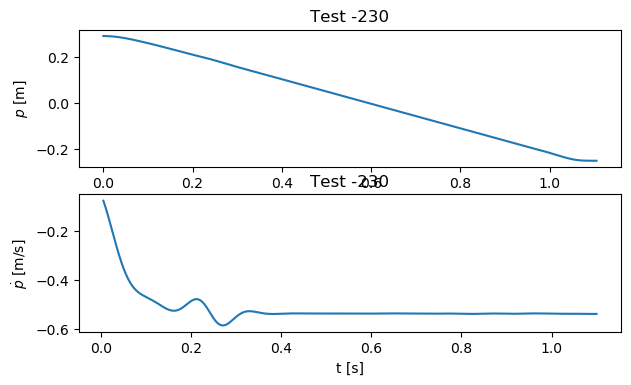

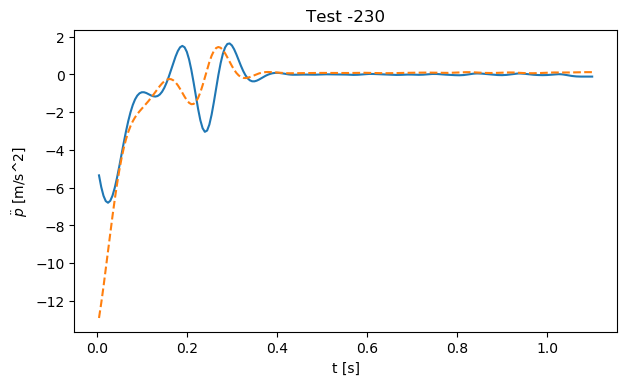

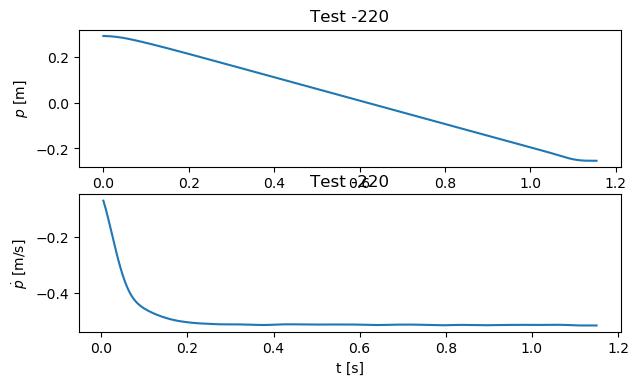

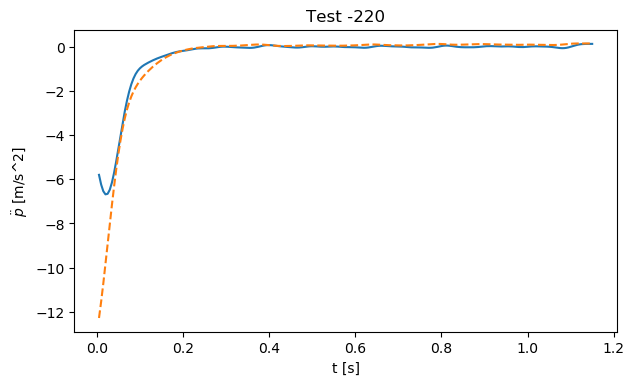

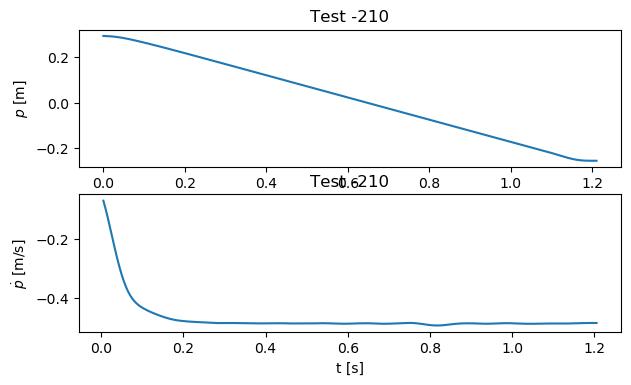

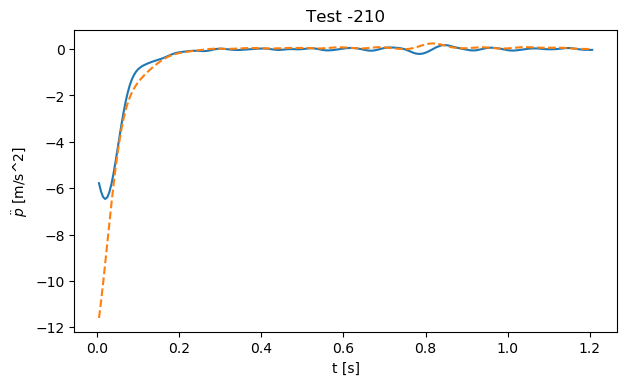

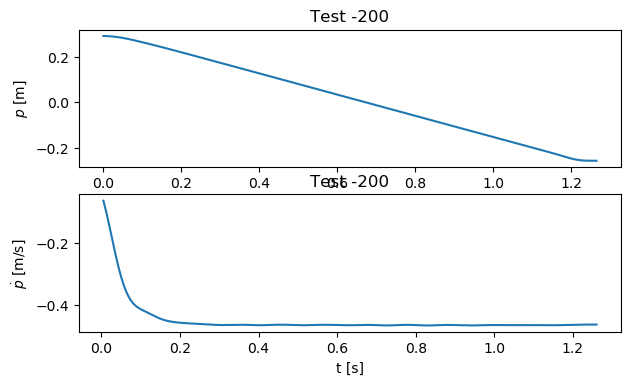

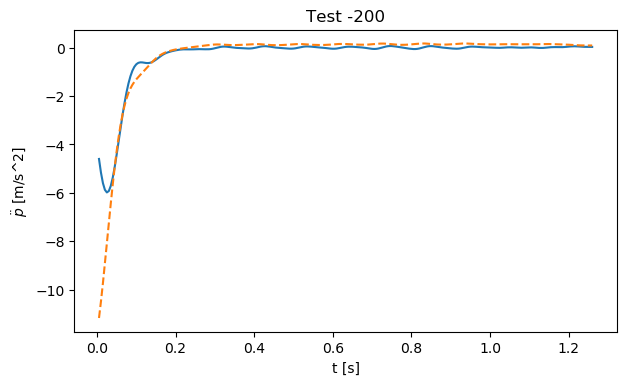

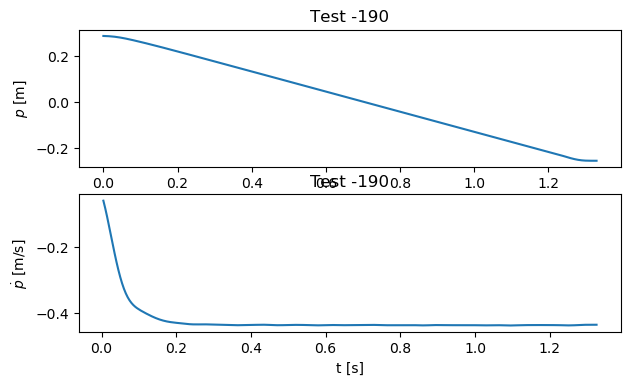

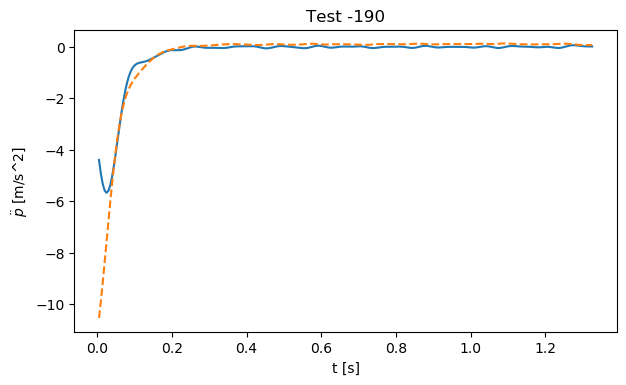

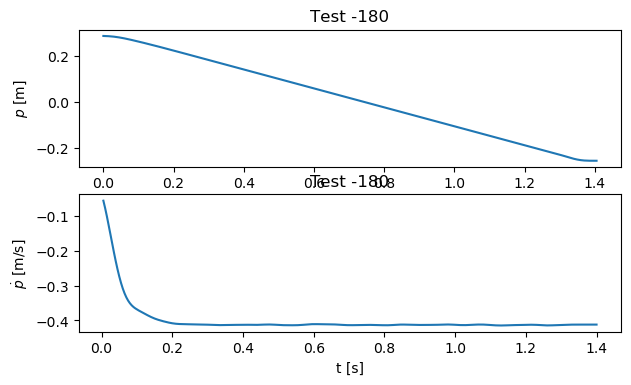

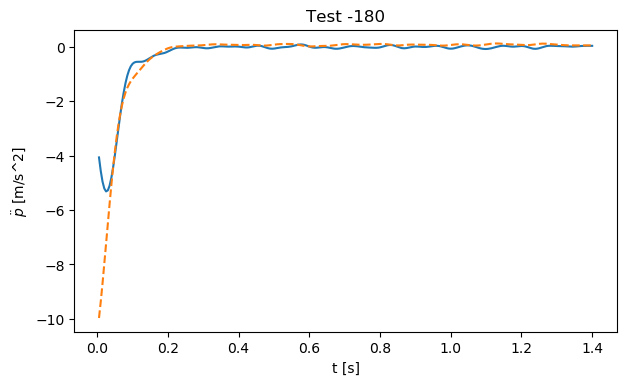

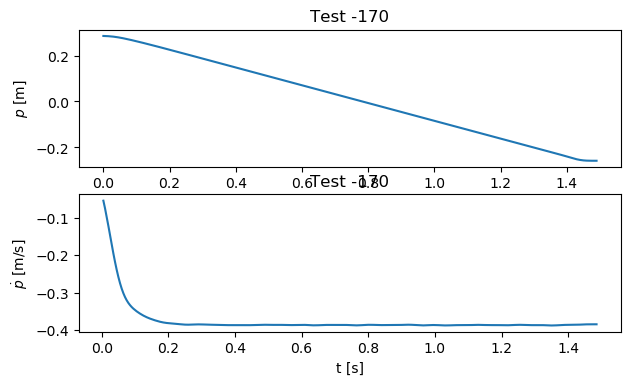

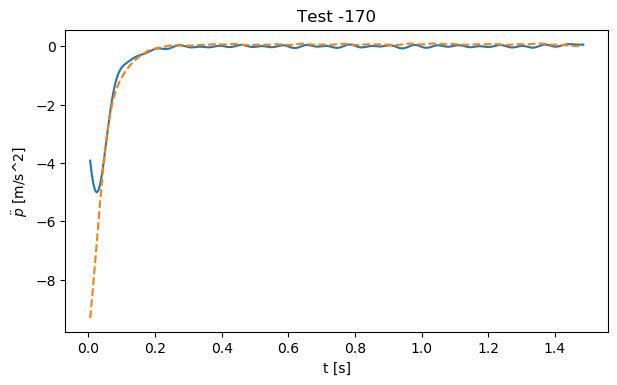

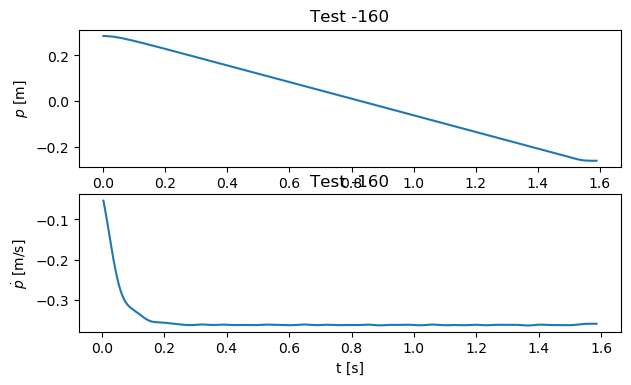

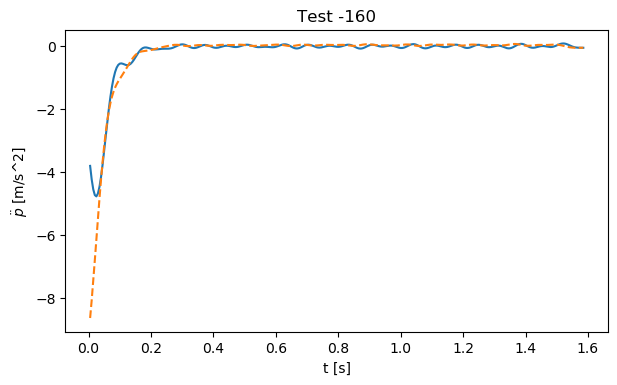

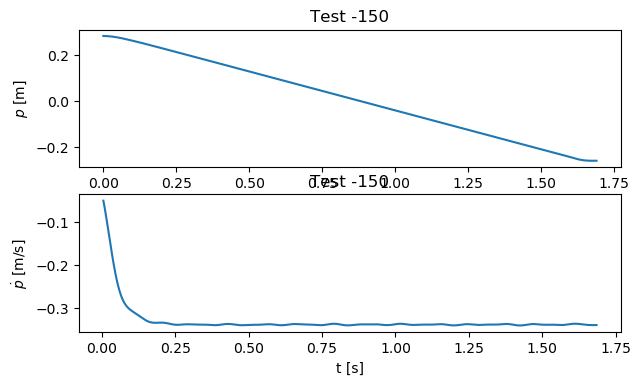

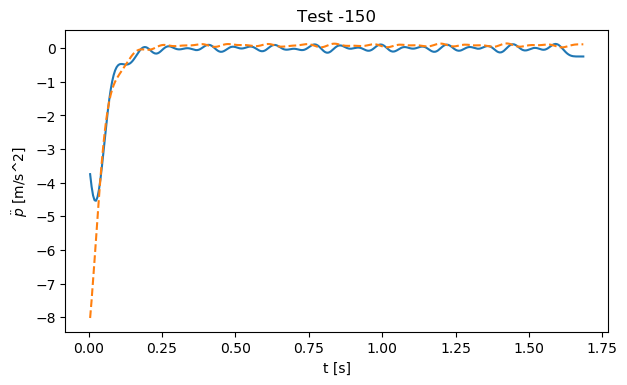

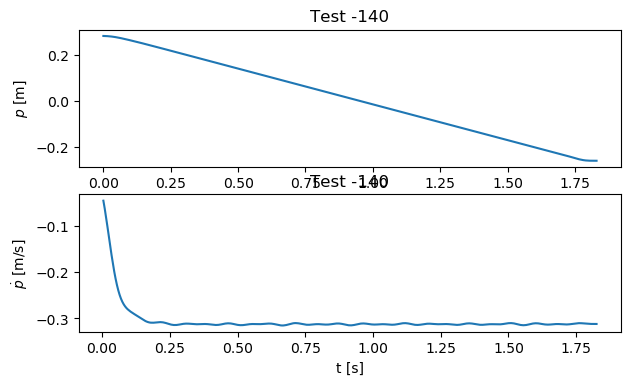

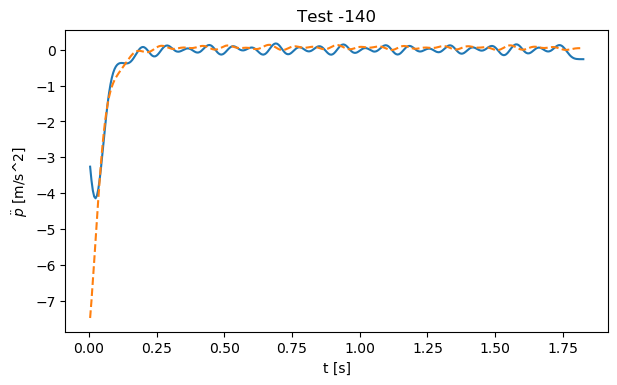

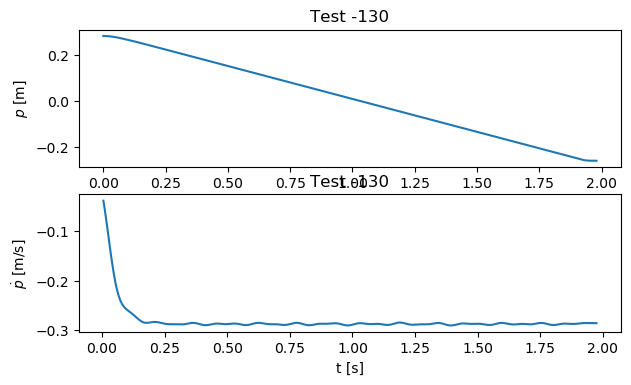

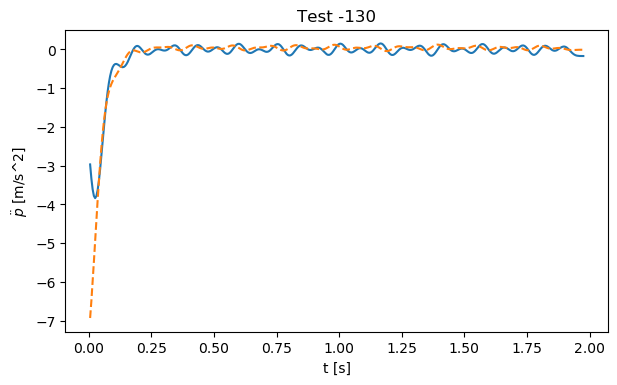

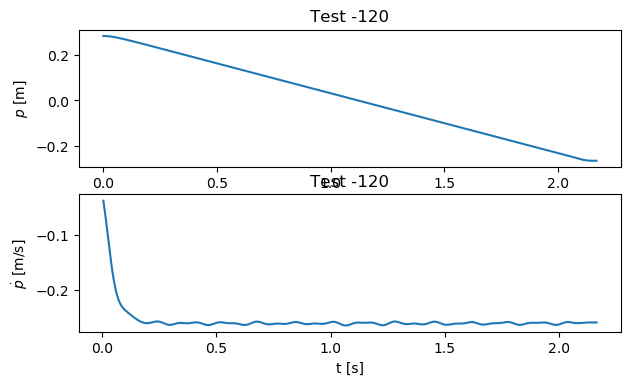

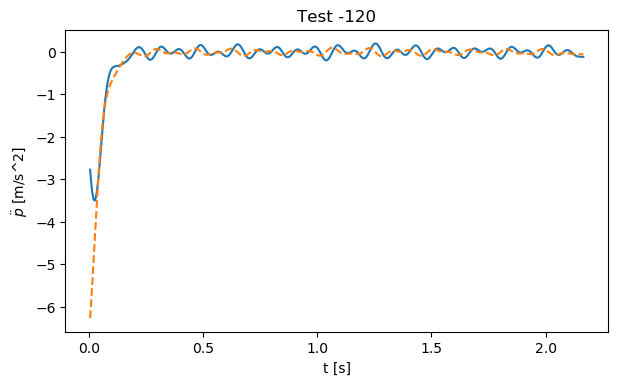

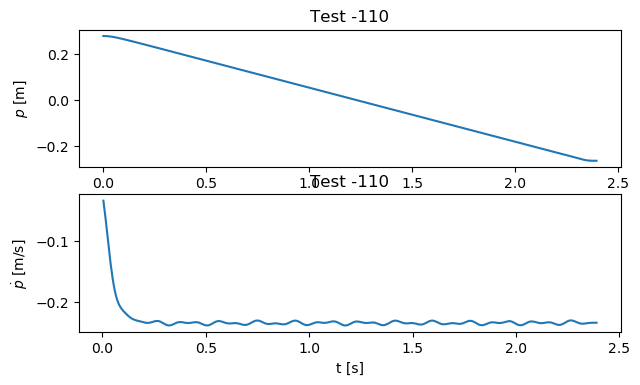

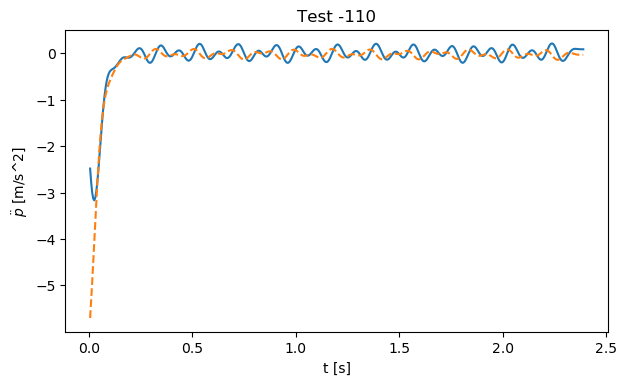

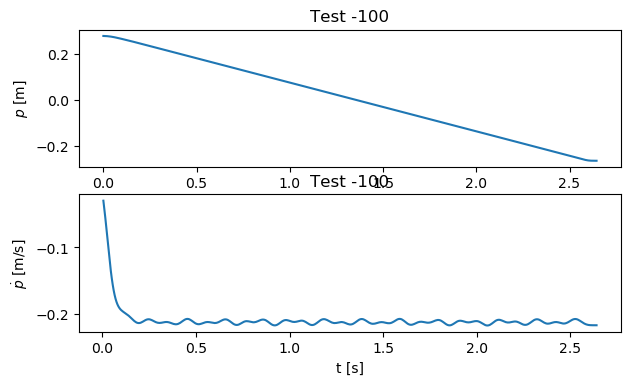

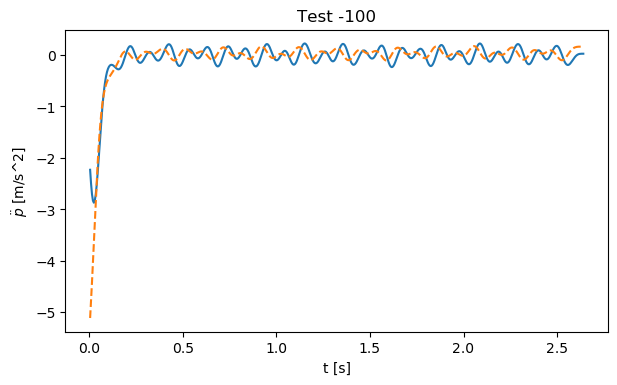

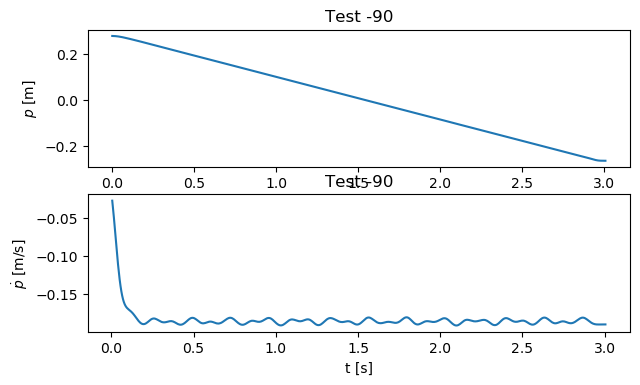

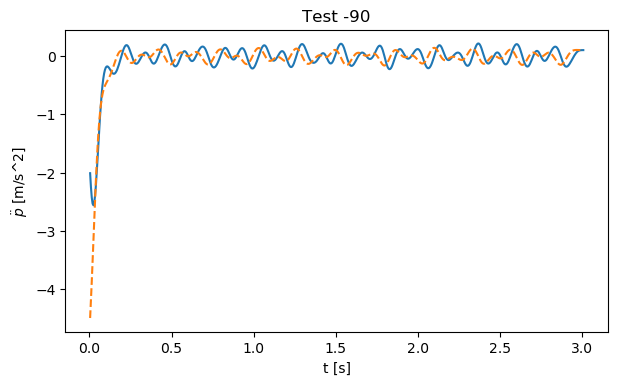

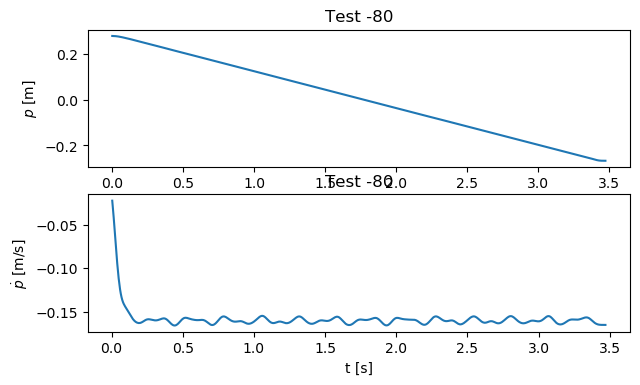

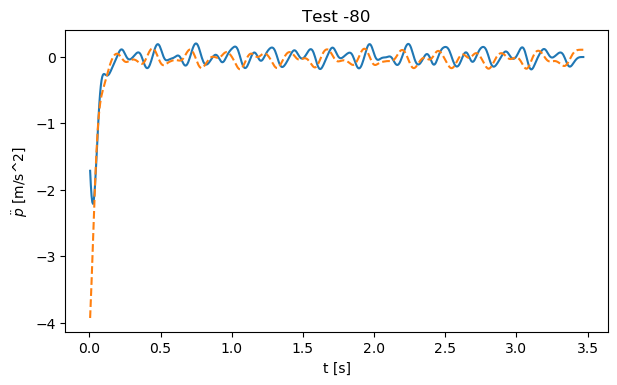

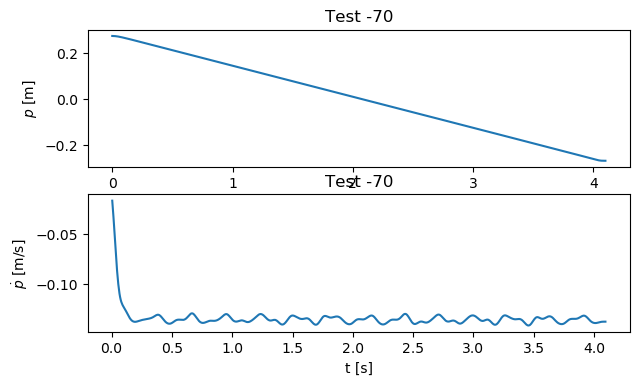

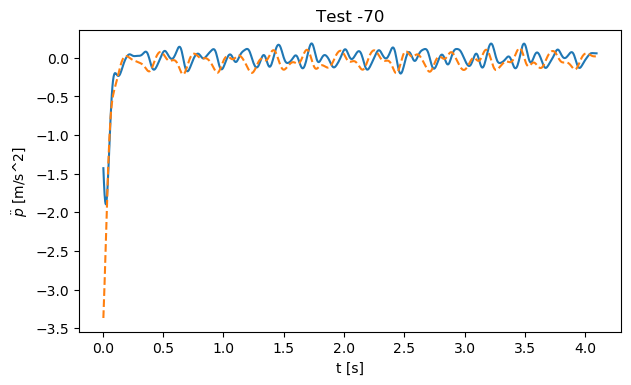

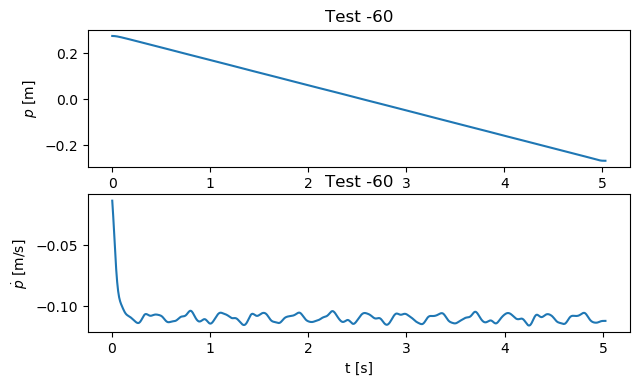

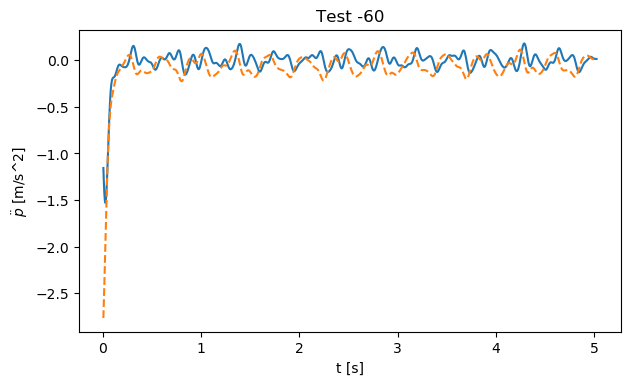

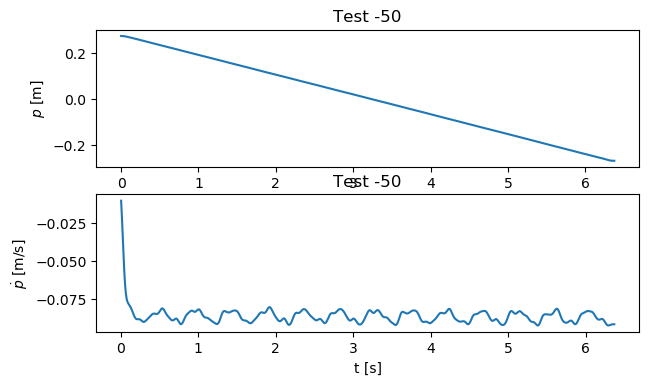

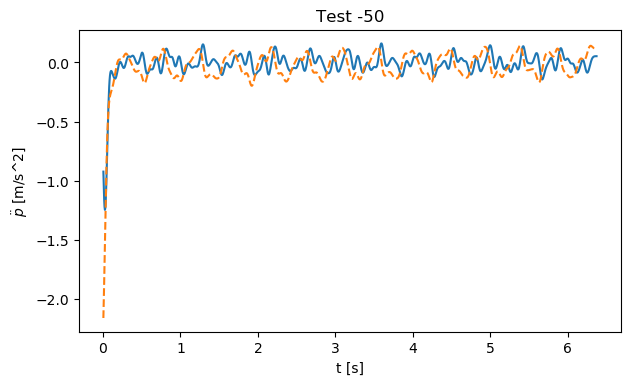

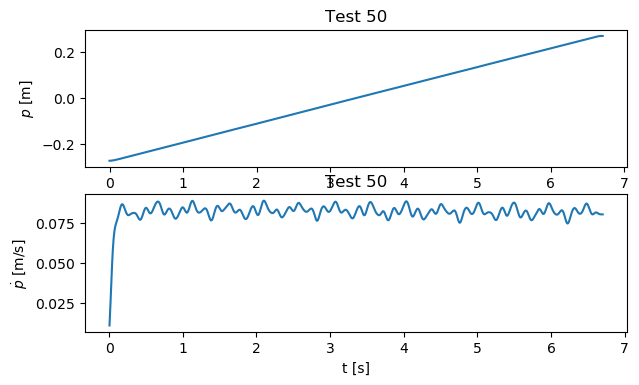

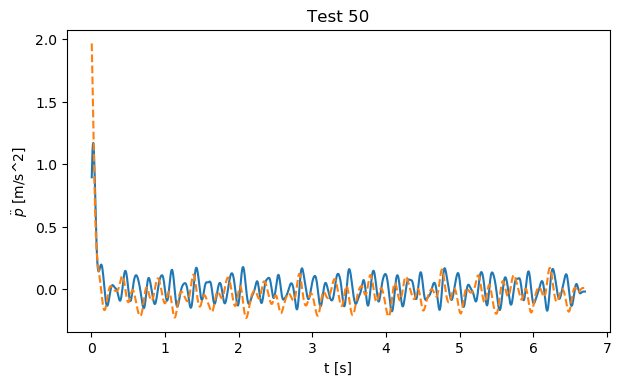

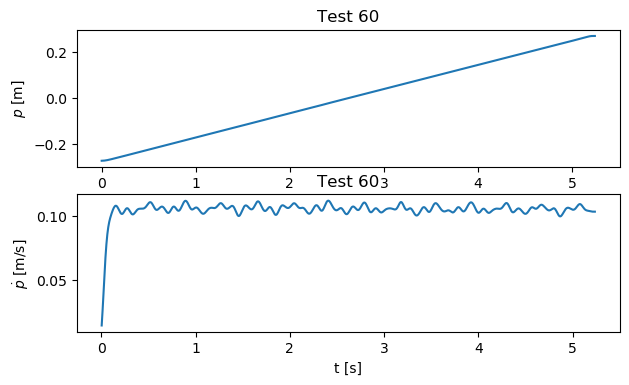

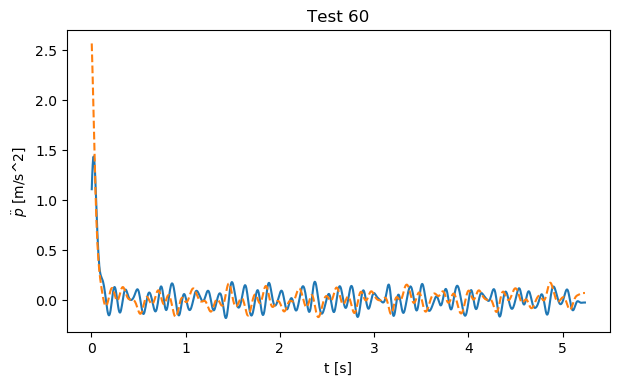

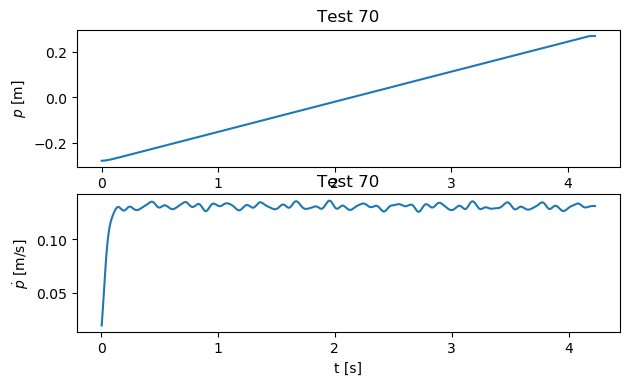

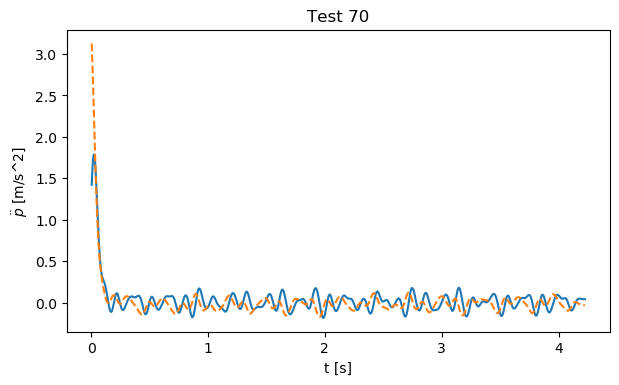

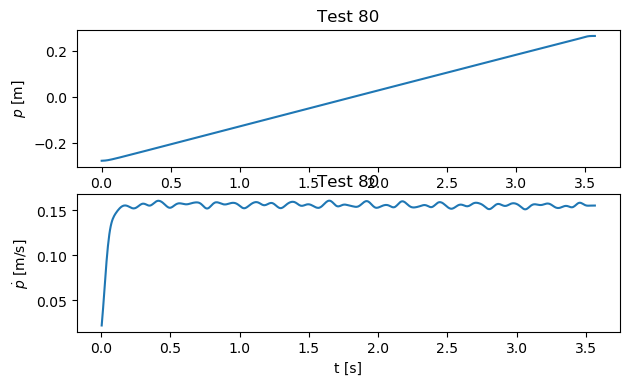

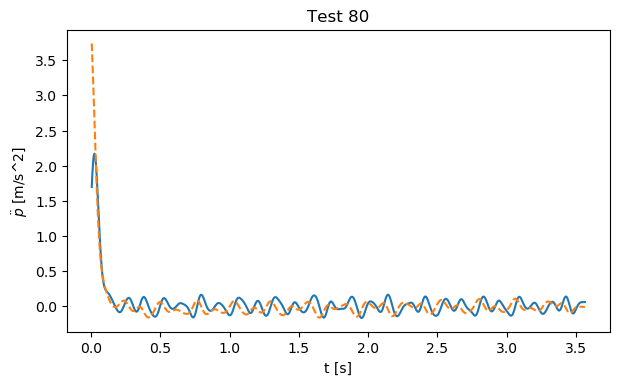

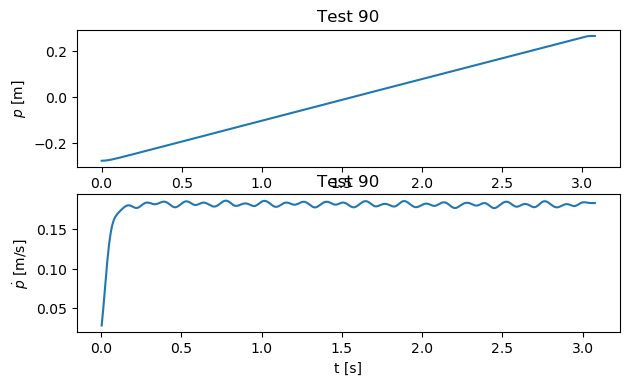

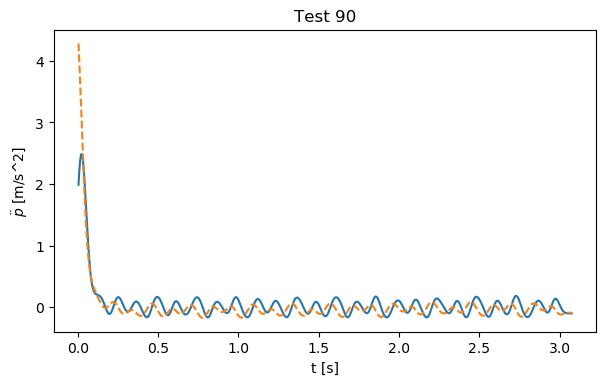

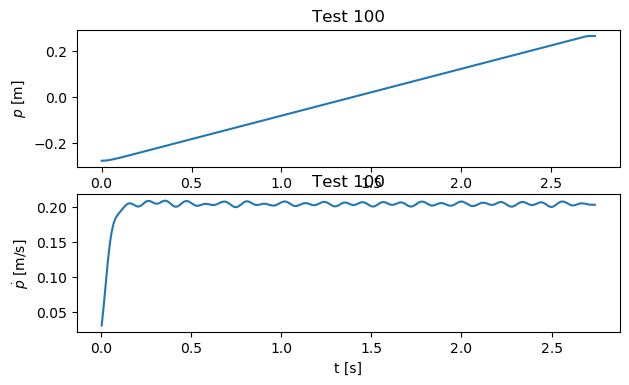

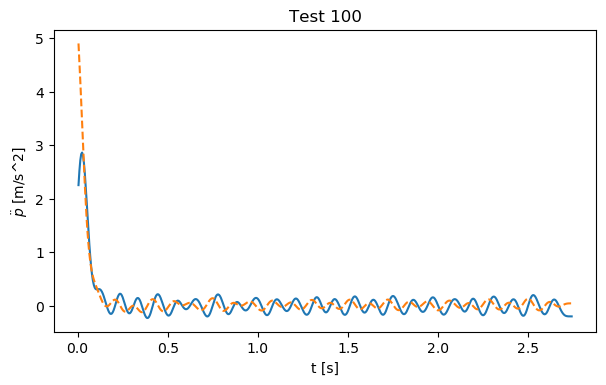

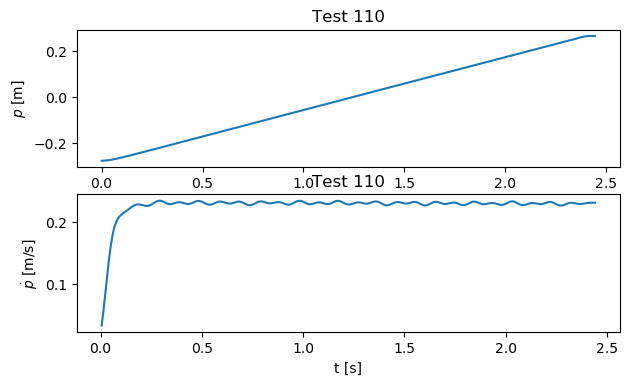

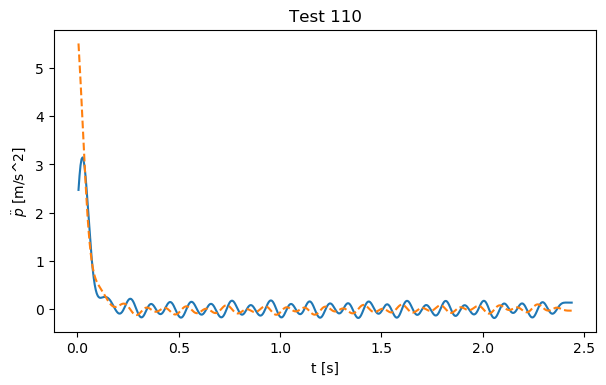

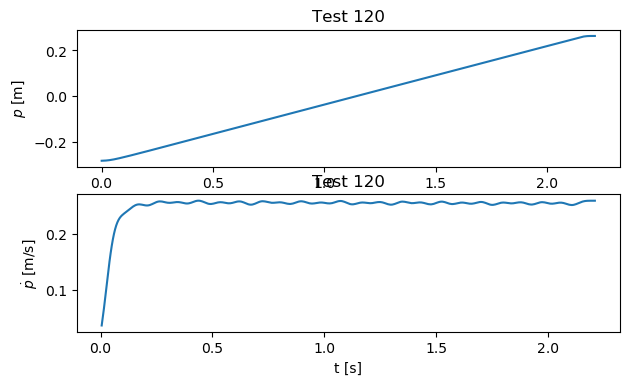

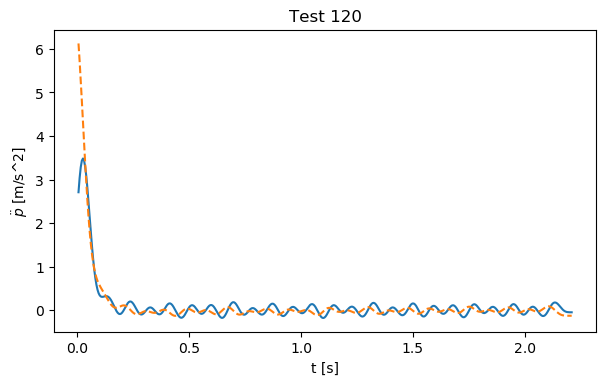

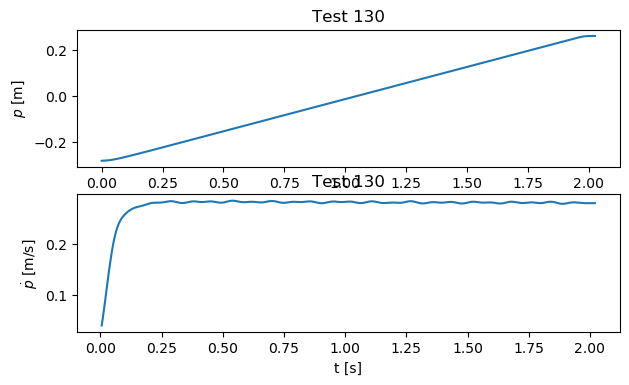

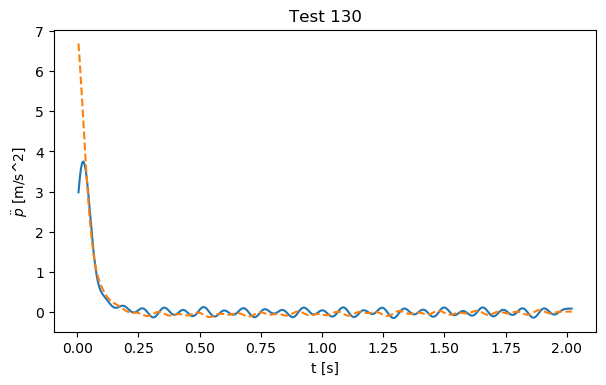

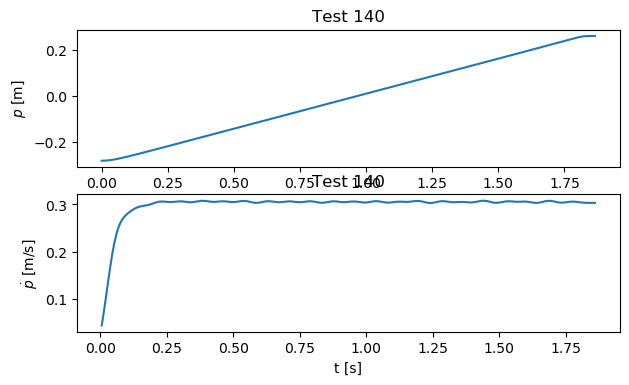

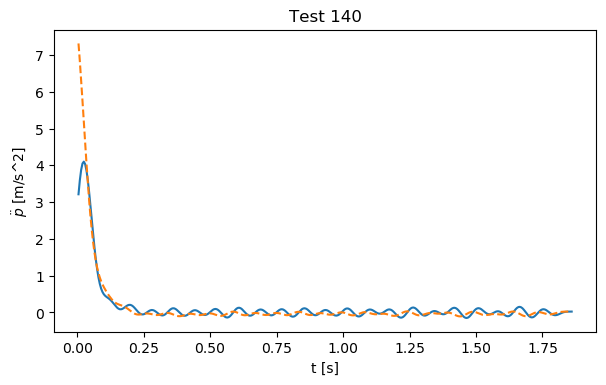

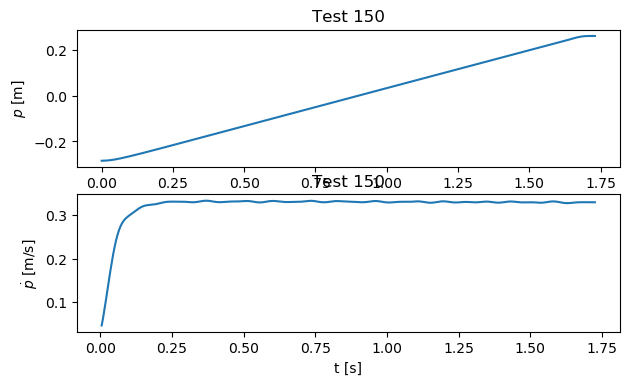

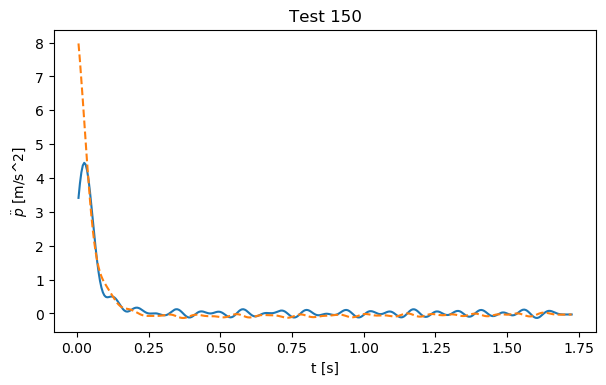

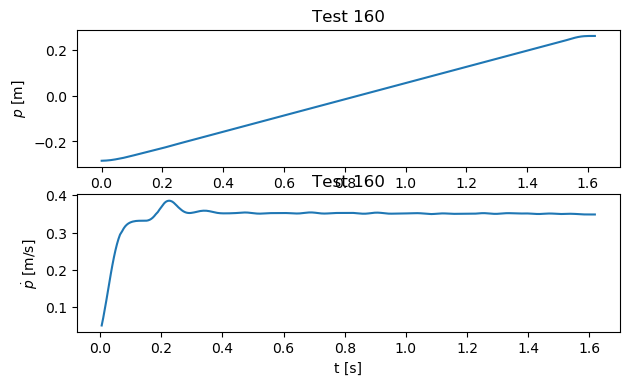

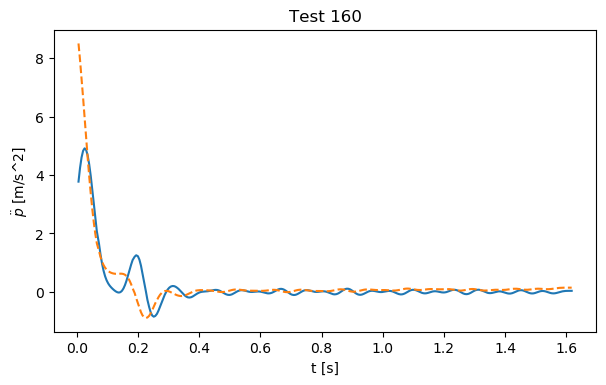

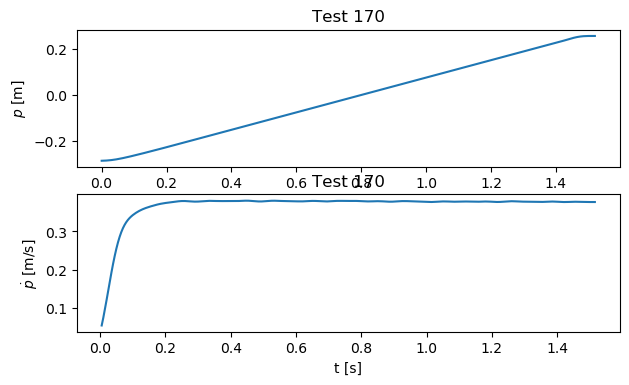

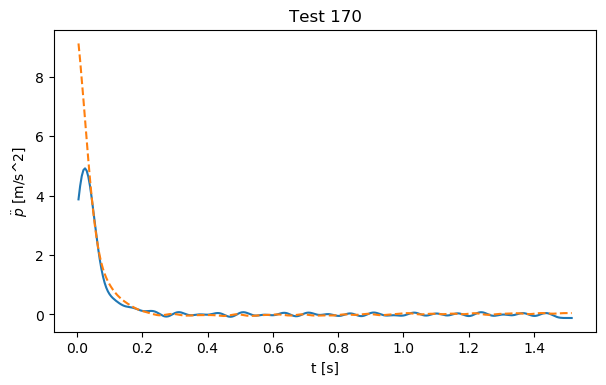

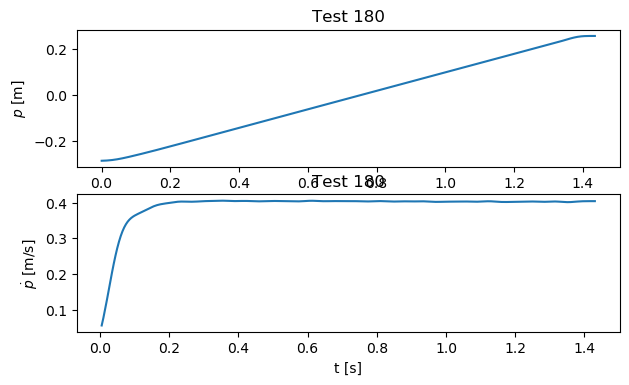

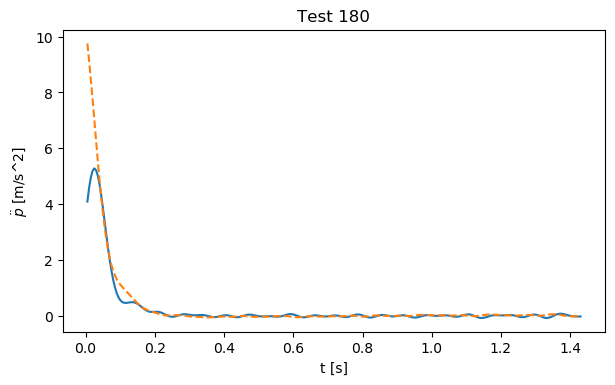

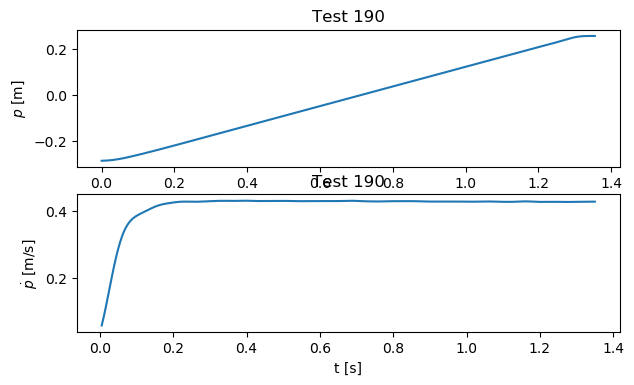

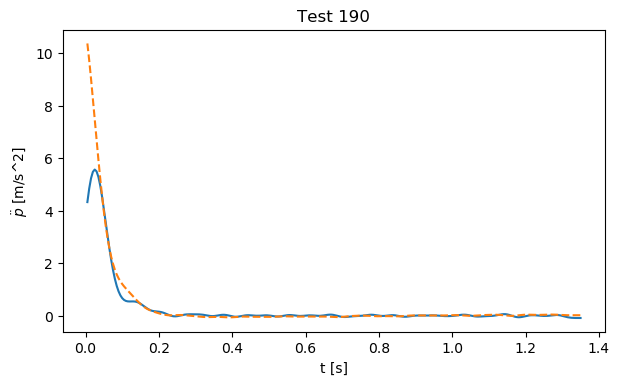

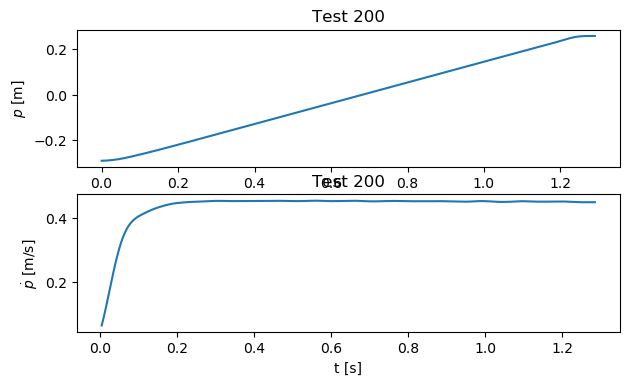

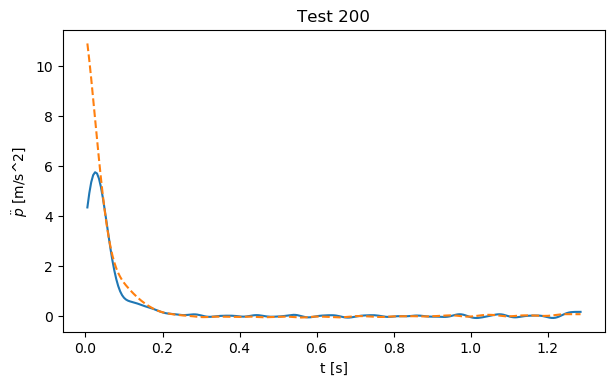

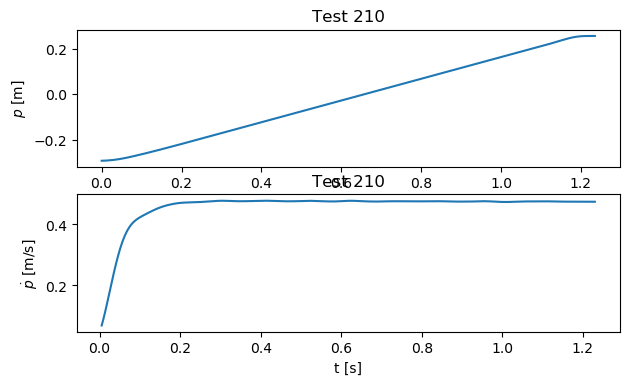

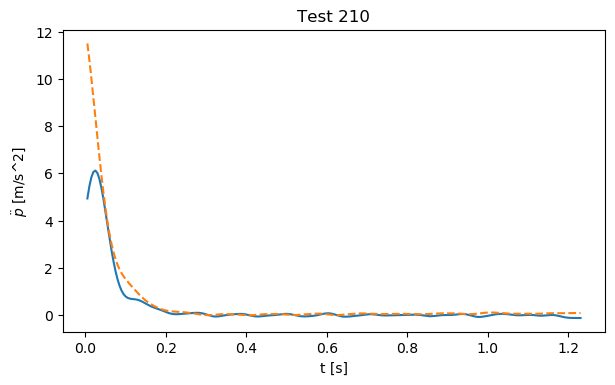

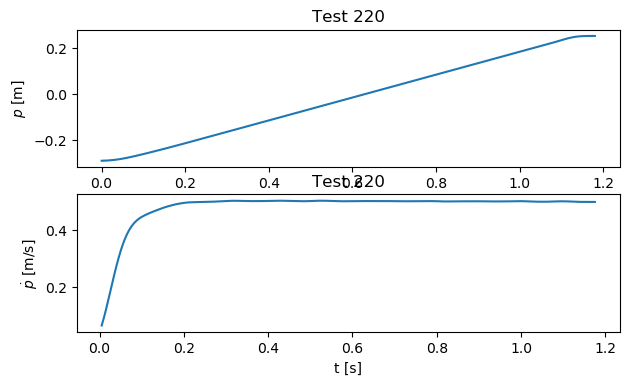

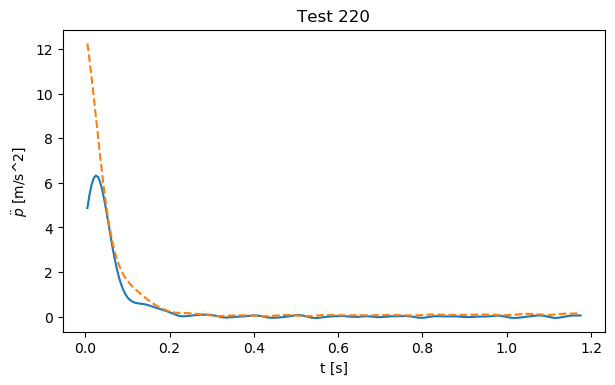

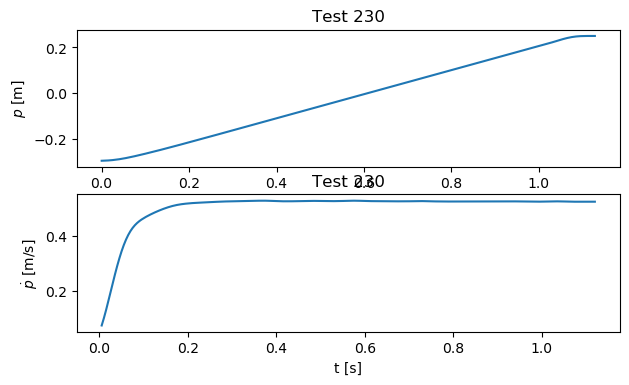

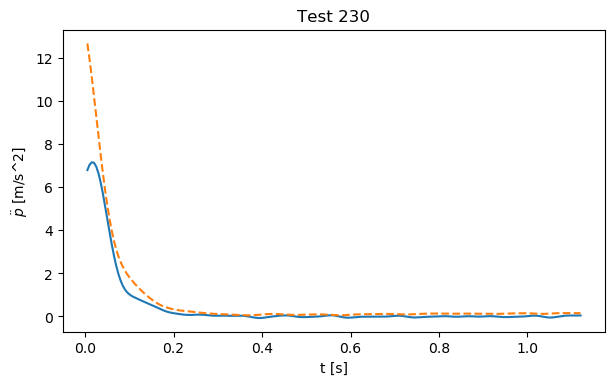

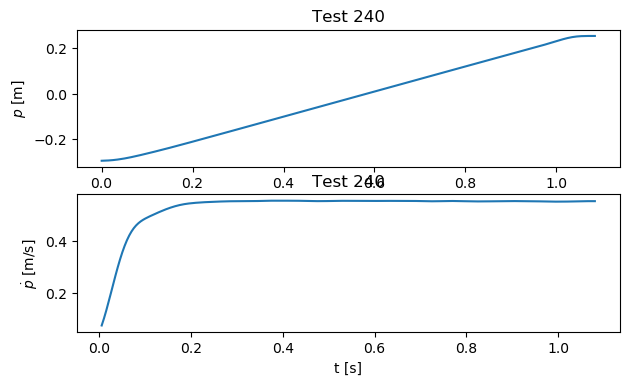

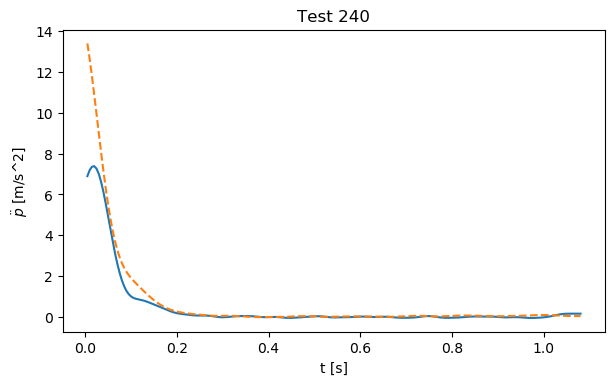

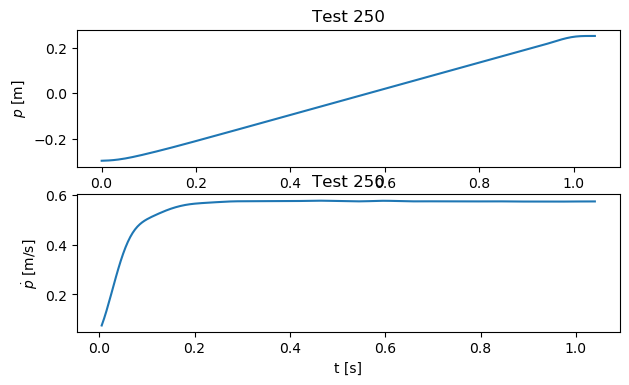

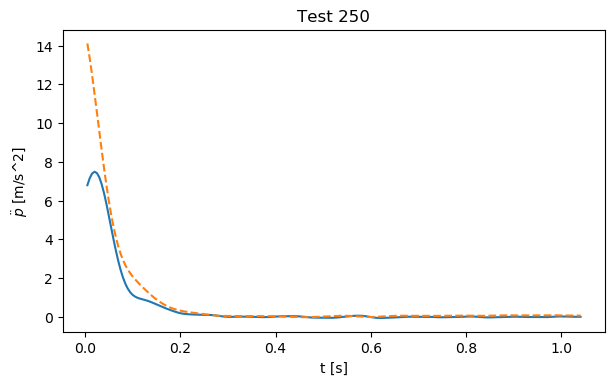

In [9]:
# Show results

for test_id, test_data in data.items():
    fig_posvel,(pos_ax,vel_ax) = plt.subplots(2,1)
    fig_acc,acc_ax = plt.subplots()
    t = test_data.get('time_us')
    t = t / 1e6
    t = t - t[0] # t[0]=0
    t2 = t[1:-1] # for velocity and acceleration signals
    dt = np.average(np.diff(t))
    # raw signals
    praw = test_data.get('position')
    vraw = np.convolve(praw, [0.5, 0, -0.5], 'valid') / dt
    araw = np.convolve(praw, [1.0, -2.0, 1.0], 'valid') / (dt**2)
    uraw = test_data.get('pwm')
    # filter the signals
    b,a = signal.butter(Nf, 2*(dt*fc)) # [1],[1,0] = no filter
    pos = signal.filtfilt(b, a, praw, padtype=None)
    vel = signal.filtfilt(b, a, vraw, padtype=None)
    acc = signal.filtfilt(b, a, araw, padtype=None)
    pwm = signal.filtfilt(b, a, uraw, padtype=None)
    # "prediction"
    ahat = alpha/M * pwm[1:-1] - beta/M * vel - alpha/M * u0 - alpha*fsa/M * np.sign(vel)
    pos_ax.plot(t, pos)
    vel_ax.plot(t2, vel)
    acc_ax.plot(t2, acc)
    acc_ax.plot(t2, ahat, '--')
    
    pos_ax.set_title(f"Test {int(test_id)}")
    pos_ax.set_xlabel('t [s]')
    pos_ax.set_ylabel('$p$ [m]')
    vel_ax.set_title(f"Test {int(test_id)}")
    vel_ax.set_xlabel('t [s]')
    vel_ax.set_ylabel('$\\dot{p}$ [m/s]')
    acc_ax.set_title(f"Test {int(test_id)}")
    acc_ax.set_xlabel('t [s]')
    acc_ax.set_ylabel('$\\ddot{p}$ [m/s^2]')
    

In [23]:
# Show the grouped parameters
ma = mt/alpha
Ia = I0/alpha
mua = mu/alpha
fva = beta/alpha
fsa = fsa
u0 = u0
tva = tau_d/alpha

print("ma =", ma)
print("Ia =", Ia)
print("mua =", mua)
print("fva =", fva)
print("fsa =", fsa)
print("u0 =", u0)
print("tva =", tva)

# Now, show the base parameters (except static friction coefficients)
print("")
print("M =", M)
print("m1 =", m1)
print("m2 =", m2)
print("m3 =", m3)
print("I =", I)
print("ell =", ell)
print("alpha =", alpha)
print("beta =", beta)
print("tau_d =", tau_d)

# finally, make sure these values are correct!
_ma = (M+m1+m2+m3) / alpha 
_Ia = (I+m2*ell**2/4+m3*ell**2) / alpha 
_mua = (m2*ell/2+m3*ell) / alpha
_fva = beta/alpha
_tva = tau_d / alpha
assert abs(ma-_ma)<1e-12, f"{ma} is not {_ma}; error: {ma-_ma}"
assert abs(Ia-_Ia)<1e-12, f"{Ia} is not {_Ia}; error: {Ia-_Ia}"
assert abs(mua-_mua)<1e-12, f"{mua} is not {_mua}; error: {mua-_mua}"
assert abs(fva-_fva)<1e-12, f"{fva} is not {_fva}; error: {fva-_fva}"
assert abs(tva-_tva)<1e-12, f"{tva} is not {_tva}; error: {tva-_tva}"


ma = 16.36107771481117
Ia = 0.29504025711512755
mua = 0.6546880349055427
fva = 403.0267679493358
fsa = 16.149267140580772
u0 = 1.313910147328636
tva = 0.02537703984258163

M = 0.439
m1 = 0.012
m2 = 0.019
m3 = 0.031
I = 0.0002749181163534918
ell = 0.495
alpha = 0.030621454694666015
beta = 12.34126591549826
tau_d = 0.0007770818758243477


In [24]:
import scipy
from control.matlab import *



# commun denominator
DL = ma*Ia - mua**2

A = np.matrix([
    [0, 1, 0, 0], 
    [0, -fva*Ia/DL, -mua**2*g/DL, -mua*tau_da/DL],
    [0, 0, 0, 1],
    [0, -mua*fva/DL, mua*g*ma/DL, -tau_da*ma/DL]
])

B = np.matrix([[0, Ia/DL, 0, mua/DL]]).T 

C = np.matrix([[1, 0, 0, 0],[0, 0, 1, 0]]) 

D = np.matrix([[0, 0]]).T 

sysc = ss(A,B,C,D)

Ts = 0.01
sysd = c2d(sysc, Ts);

Q = np.matrix([
    [1000, 0, 0,   0],
    [0,  .05, 0,   0],
    [0,   0, 15, 0],
    [0,   0, 0,  .05],
])

R = np.matrix([0.05])

"""
Solve the discrete time lqr controller.
#ref Bertsekas, p.151 
x[k+1] = A x[k] + B u[k]
cost = sum x[k].T*Q*x[k] + u[k].T*R*u[k]
"""
#first, try to solve the ricatti equation
P = np.matrix(scipy.linalg.solve_discrete_are(sysd.A, sysd.B, Q, R))     
#compute the LQR gain
K = np.array(scipy.linalg.inv(sysd.B.T*P*sysd.B+R)*(sysd.B.T*P*sysd.A)).reshape(-1)
print("LQR gain:", K)

print("\nC++ code:")
print(f"const double kp = {K[0]};")
print(f"const double kpd = {K[1]};")
print(f"const double kt = {K[2]};")
print(f"const double ktd = {K[3]};")

print("\nYAML code:")
print(f"gains:")
print(f"  kp: {K[0]}")
print(f"  kpd: {K[1]}")
print(f"  kt: {K[2]}")
print(f"  ktd: {K[3]}")

LQR gain: [-134.25866139 -844.31941255 2293.22544813  448.56961007]

C++ code:
const double kp = -134.25866138530708;
const double kpd = -844.319412554349;
const double kt = 2293.2254481318246;
const double ktd = 448.5696100686629;

YAML code:
gains:
  kp: -134.25866138530708
  kpd: -844.319412554349
  kt: 2293.2254481318246
  ktd: 448.5696100686629
